# Práctica de Machine Learning
### Preprocesado y entrenamiento

Comenzamos importando las librerías y cargando los datos que me he quedado para hacer el entrenamiento.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

train = pd.read_csv('./train.csv',sep=';', decimal='.')

Antes de nada me voy a sacar una matriz de correlación para hacer una primera limpieza superficial, ya que tengo demasiadas variables.

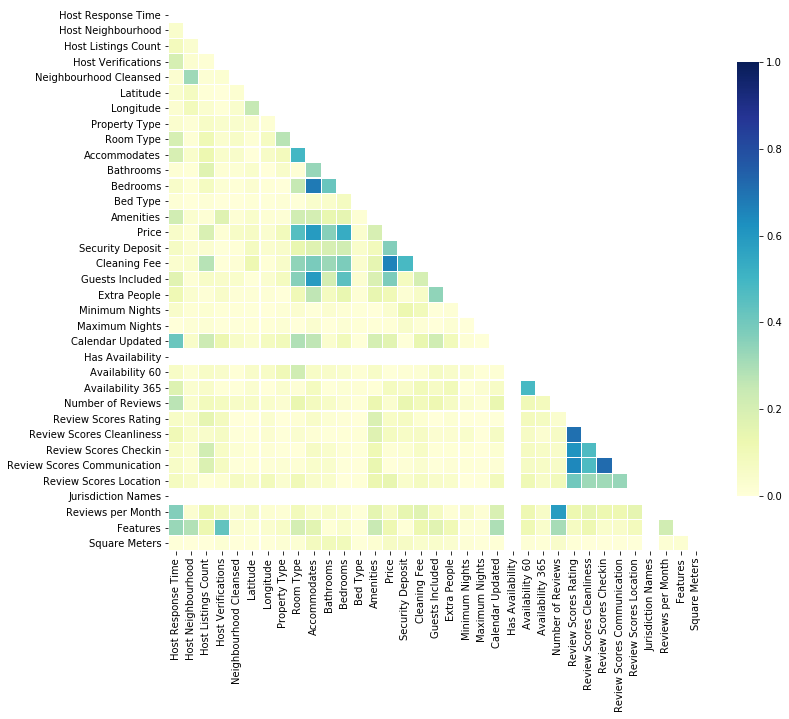

In [30]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [3]:
# Availability 30, 60 y 90 me indican prácticamente lo mismo (disponibilidad a medio/largo plazo)
# Me quedaré únicamente con avaiability 60 por ser la que está en medio.

train = train.drop(columns=['Availability 30', 'Availability 90'])

In [4]:
# Host Listings Count, Host Total Listings Count y Calculated host listings count también parecen indicarme algo similar.
# Me quedo con la primera de las tres, ya que las otras dos parecen haber sido calculadas a posteriori.

train = train.drop(columns=['Host Total Listings Count','Calculated host listings count'])

In [5]:
# Beds y accomodates también parecen hacer referencia a lo mismo (camas o muebles "para quedarse a dormir").
# Me quedo con accomodates ya que a priori parece más preciso y además tiene una correlación más alta con la variable objetivo.

train = train.drop(columns=['Beds'])

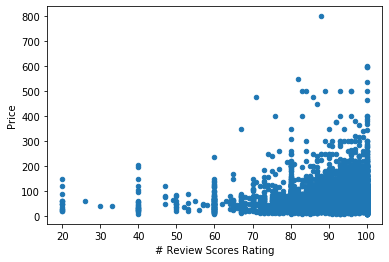

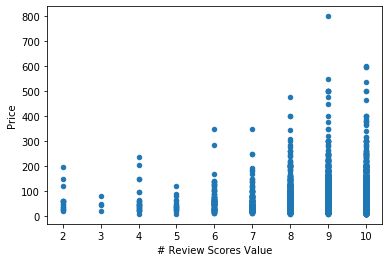

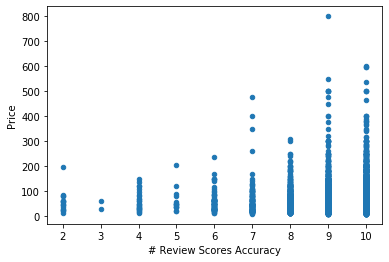

In [6]:
# Review Scores Rating, Review Scores Value y Review Scores Accuracy también tienen valores muy similares en relación al precio.

train.plot(kind='scatter', x='Review Scores Rating', y='Price')
plt.xlabel('# Review Scores Rating')
plt.ylabel('Price')
plt.show()

train.plot(kind='scatter', x='Review Scores Value', y='Price')
plt.xlabel('# Review Scores Value')
plt.ylabel('Price')
plt.show()

train.plot(kind='scatter', x='Review Scores Accuracy', y='Price')
plt.xlabel('# Review Scores Accuracy')
plt.ylabel('Price')
plt.show()

In [7]:
print(f"NaN en Review Scores Rating: {sum(train['Review Scores Rating'].isnull())}\n"+
      f"Nan en Review Scores Value: {sum(train['Review Scores Value'].isnull())}\n"+
      f"Nan en Review Scores Accuracy: {sum(train['Review Scores Accuracy'].isnull())}")

NaN en Review Scores Rating: 2265
Nan en Review Scores Value: 2287
Nan en Review Scores Accuracy: 2280


No tengo muy claro cuál de las tres me va a dar los mejores resultados, así que me quedaré con la primera por ser la que menos valores nulos contiene.

In [8]:
train = train.drop(columns=['Review Scores Value','Review Scores Accuracy'])

Hago un segundo repaso sobre las variables que tengo para decidir qué hacer con ellas.

In [9]:
train.columns

Index(['Last Scraped', 'Experiences Offered', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate',
       'Host Neighbourhood', 'Host Listings Count', 'Host Verifications',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'Zipcode', 'Market', 'Smart Location',
       'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Bed Type', 'Amenities', 'Square Feet',
       'Price', 'Security Deposit', 'Cleaning Fee', 'Guests Included',
       'Extra People', 'Minimum Nights', 'Maximum Nights', 'Calendar Updated',
       'Has Availability', 'Availability 60', 'Availability 365',
       'Calendar last Scraped', 'Number of Reviews', 'First Review',
       'Last Review', 'Review Scores Rating', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'License', 'Jurisdiction Names',
       'Cancellation Pol

In [10]:
#train[''].value_counts()

Le doy un valor a Calendar Updated en base a la temporalidad

In [11]:
train['Calendar Updated'] = train['Calendar Updated'].apply(lambda x: 5 if "today" in str(x) else
                                                           4 if "yesterday" in str(x) else
                                                           3 if "day" in str(x) else
                                                           2 if "week" in str(x) else
                                                           1 if "month" in str(x) else 0)

Me transformo los pies cuadrados a metros cuadrados, ya que es una medida que controlo mejor.

In [12]:
train['Square Meters'] = train['Square Feet']*0.092903
train = train.drop(columns=['Square Feet'])

Hay ciertos datos que no tienen sentido. Por ejemplo no puede haber pisos con 0m, y un piso con dos habitaciones que mida menos de 30m o un piso con menos de 15m también serían casos practicamente imposibles.

In [13]:
train.loc[train['Square Meters'] < 15, 'Square Meters'] = np.nan
train.loc[(train['Square Meters'] < 30) & (train['Bedrooms'] > 1) , 'Square Meters'] = np.nan

In [14]:
train['Square Meters'] = train['Square Meters'].fillna(train['Square Meters'].mean())

In [15]:
print(f"Apartment: {train[train['Property Type']=='Apartment']['Price'].describe()}",
     f"House: {train[train['Property Type']=='House']['Price'].describe()}",
     f"Condominium: {train[train['Property Type']=='Condominium']['Price'].describe()}",
     f"Bed & Breakfast: {train[train['Property Type']=='Bed & Breakfast']['Price'].describe()}",
     f"Loft: {train[train['Property Type']=='Loft']['Price'].describe()}",
     f"Other: {train[train['Property Type']=='Other']['Price'].describe()}",
     f"Dorm: {train[train['Property Type']=='Dorm']['Price'].describe()}",
     f"Guesthouse: {train[train['Property Type']=='Guesthouse']['Price'].describe()}",
     f"Chalet: {train[train['Property Type']=='Chalet']['Price'].describe()}",
     f"Hostel: {train[train['Property Type']=='Hostel']['Price'].describe()}",
     f"Serviced apartment: {train[train['Property Type']=='Serviced apartment']['Price'].describe()}", sep='\n\n')

Apartment: count    8724.000000
mean       67.652797
std        55.174927
min        10.000000
25%        33.000000
50%        55.000000
75%        82.000000
max       800.000000
Name: Price, dtype: float64

House: count    775.000000
mean      57.541935
std       61.830501
min        9.000000
25%       25.000000
50%       39.000000
75%       69.000000
max      750.000000
Name: Price, dtype: float64

Condominium: count    266.000000
mean      62.710526
std       54.826956
min       10.000000
25%       30.000000
50%       50.000000
75%       74.250000
max      550.000000
Name: Price, dtype: float64

Bed & Breakfast: count    253.000000
mean      37.984190
std       42.164452
min       15.000000
25%       24.000000
50%       30.000000
75%       45.000000
max      650.000000
Name: Price, dtype: float64

Loft: count    229.000000
mean      75.301310
std       62.320838
min       17.000000
25%       48.000000
50%       60.000000
75%       85.000000
max      750.000000
Name: Price, dtype: fl

Basándome en los datos y un poco en mi intuición establezco cuatro categorías según la relación del tipo de vivienda con el precio.

In [16]:
# Gama alta: Loft, Chalet
# Gama media-alta: Apartment, Condominium, Other
# Gama media: House, Serviced apartment
# Gama baja: Bed & Breakfast, Dorm, Guesthouse, Hostel

train['Property Type'] = train['Property Type'].apply(lambda x: {
    'Bed & Breakfast': 1,
    'Dorm': 1,
    'Guesthouse': 1,
    'Hostel': 1,
    'House': 2,
    'Serviced apartment': 2,
    'Apartment': 3,
    'Condominium': 3,
    'Other': 3,
    'Loft': 4,
    'Chalet': 4
}.get(x))

train.loc[train['Property Type'].isnull(), 'Property Type'] = 0

Aplico la misma lógica a Room Type, aunque aquí me fiaré de mi intuición, ya que la diferencia de calidad se hace más evidente.

In [17]:
train['Room Type'] = train['Room Type'].apply(lambda x: {
    'Shared room': 1,
    'Private room': 2,
    'Entire home/apt': 3
}.get(x))

Hago lo mismo con Bed Type

In [18]:
train['Bed Type'] = train['Bed Type'].apply(lambda x: {
    'Real Bed': 3,
    'Pull-out Sofa': 2,
    'Futon': 1,
    'Couch': 2
}.get(x))

train.loc[train['Bed Type'].isnull(), 'Bed Type'] = 0

Establezco un orden de valores para cada una de las variables de Host Response Time, dando una mayor puntuación a los que tienen el tiempo de respuesta más bajo

In [19]:
train['Host Response Time'] = train['Host Response Time'].apply(lambda x: {
    'a few days or more': 1,
    'within a day': 2,
    'within a few hours': 3,
    'within an hour': 4
}.get(x))

train.loc[train['Host Response Time'].isnull(), 'Host Response Time'] = 0

In [20]:
train['Host Response'] = train['Host Response Rate']*train['Host Response Time']
train[['Host Response','Host Response Time','Host Response Rate','Price']].corr()

,Host Response,Host Response Time,Host Response Rate,Price
Host Response,1.000000,0.976040,0.741107,0.023907
Host Response Time,0.976040,1.000000,0.612391,0.053232
Host Response Rate,0.741107,0.612391,1.000000,-0.006232
Price,0.023907,0.053232,-0.006232,1.000000


In [21]:
# Me quedo con Host Response Time de momento.

train = train.drop(columns=['Host Response','Host Response Rate'])

Hay tres variables que parecen indicar el barrio. Una parece originaria del scrap y dos de ellas parecen haber sido creadas a posteriori. De momento las transformaré todas y después analizaré cual de las tres me podría dar mejores resultados.

In [22]:
from sklearn.preprocessing import LabelEncoder

train['Neighbourhood'] = train['Neighbourhood'].fillna('Unknown')
train['Neighbourhood Cleansed'] = train['Neighbourhood Cleansed'].apply(lambda x: 'Unknown' if x == 'Orcasitas' else x)
train['Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].apply(lambda x: 'Unknown' if x == 'Vicálvaro' else x)

encoderNeigh = LabelEncoder().fit(list(train['Neighbourhood'].dropna().unique()))
encoderNeighCl = LabelEncoder().fit(list(train['Neighbourhood Cleansed'].dropna().unique()))
encoderNeighGCl = LabelEncoder().fit(list(train['Neighbourhood Group Cleansed'].dropna().unique()))

train['Neighbourhood'] = encoderNeigh.transform(train['Neighbourhood'])
train['Neighbourhood Cleansed'] = encoderNeighCl.transform(train['Neighbourhood Cleansed'])
train['Neighbourhood Group Cleansed'] = encoderNeighGCl.transform(train['Neighbourhood Group Cleansed'])

train[['Neighbourhood','Neighbourhood Cleansed','Neighbourhood Group Cleansed','Price']].corr()

,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Price
Neighbourhood,1.000000,0.396318,-0.008875,0.003483
Neighbourhood Cleansed,0.396318,1.000000,-0.170739,0.055217
Neighbourhood Group Cleansed,-0.008875,-0.170739,1.000000,-0.037512
Price,0.003483,0.055217,-0.037512,1.000000


In [23]:
# Ninguna de ellas parece importante.
# Neighbourhood tiene demasiados valores nan
# Neighbourhood Group Cleansed parece una agrupación que no sé de dónde sale.
# De momento me quedo con Neighbourhood Cleansed.

train = train.drop(columns=['Neighbourhood','Neighbourhood Group Cleansed'])

In [24]:
print(train[train['Market']=='Madrid']['Price'].describe(),
      train[train['Market']=='Other (International)']['Price'].describe(),
      train[(train['Market']=='Toledo') | (train['Market']=='Deauville')]['Price'], sep='\n\n')

count    10519.000000
mean        65.983554
std         55.762622
min          9.000000
25%         30.000000
50%         52.000000
75%         80.000000
max        800.000000
Name: Price, dtype: float64

count      7.000000
mean     136.142857
std      205.643242
min       25.000000
25%       49.500000
50%       60.000000
75%       84.500000
max      600.000000
Name: Price, dtype: float64

3784    95.0
4276    35.0
Name: Price, dtype: float64


Casi todas las entradas están en el mercado de Madrid, y no veo que haya una clara diferencia en el margen de precios en ninguna de las variables, por lo que deduzco que esta caracteristica no me va a aportar nada.

In [25]:
train = train.drop(columns=['Market'])

Ciertas variables presentan una serie de características y de momento voy a asignarles un valor en función del número de características. Más adelante veré si esto me aporta información para predecir el precio o si son variables deshechables.

In [26]:
train['Host Verifications'] = train['Host Verifications'].apply(lambda x: len(str(x).split(',')))
train['Features'] = train['Features'].apply(lambda x: len(x.split(',')))
train['Amenities'] = train['Amenities'].apply(lambda x: len(str(x).split(',')))

In [27]:
# Codifico el resto de variables categóricas

train['Host Neighbourhood'] = train['Host Neighbourhood'].fillna('Unknown')

encoderHostNeigh = LabelEncoder().fit(list(train['Host Neighbourhood'].dropna().unique()))

train['Host Neighbourhood'] = encoderHostNeigh.transform(train['Host Neighbourhood'])

Las siguientes variables las voy a deshechar por no presentar diferentes valores o por estar enteramente vacías

In [28]:
train = train.drop(columns=['Experiences Offered', 'Host Acceptance Rate', 'Smart Location'])

In [29]:
# Limpiar Zipcode